In [1]:
# -*- coding: utf-8 -*-
"""3rd_mini_project_interior.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/16IQ6gAkayg_z9WubpZ38KBGZqTQHegsf
# 데이터 불러오기
"""

import torch 
import random

import torchvision
from torchvision import datasets 
from torchvision import transforms

import glob
import os
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import cv2

from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from tqdm import tqdm 

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# import matplotlib.pyplot as plt
# plt.rc('font', family='NanumBarunGothic')


In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CNN/data/'


"""# 데이터 전처리 시작"""

In [6]:
# origin = df

filepath = glob.glob(data_dir + 'train/*/*.png')

In [7]:

df = pd.DataFrame(columns=['image','label'])

df

,image,label


In [8]:

df['image'] = filepath
df['label']=df['image'].str.split('/').str[-2]
df

,image,label
0,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,가구수정
1,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,가구수정
2,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,가구수정
3,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,가구수정
4,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,가구수정
...,...,...
3452,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,훼손
3453,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,훼손
3454,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,훼손
3455,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,훼손


In [9]:
df['label'].nunique()

19

In [10]:

encoding = LabelEncoder()
df['label_encoding'] = encoding.fit_transform(df['label'])
df['label_encoding'].nunique()
# encoding.inverse_transform (encoding 한 코드 다시 원본으로 )

train_set, valid_set , _,_ = train_test_split(df,df['label_encoding'],test_size=0.2, stratify=df['label_encoding'],random_state=42)
# stratify : class 비율을 일정하게 만들어 준다. Target 값으로 넣어주면 그 값의 비율에 맞게 나누어 주기 때문에 꼭 필요!


# 나만의 데이터셋 만들기

In [11]:
len(train_set), len(valid_set)

(2765, 692)

In [12]:
# FIRST
# transform = A.Compose([A.Resize(300, 300),  A.Normalize(), A.RandomRotate90(), ToTensorV2()])

# SECOND
transform = A.Compose([A.Resize(500, 500), A.Normalize(), 
                       A.RandomRotate90(), A.HorizontalFlip(p=1), 
                       A.VerticalFlip(p=3), ToTensorV2()])

In [13]:

class MyData(Dataset):
    def __init__(self, image_filepath, label_filepath, transform=None):
        self.image_filepath = image_filepath
        self.label_filepath = label_filepath
        self.transform = transform

    def __len__(self):
        return len(self.image_filepath)

    def __getitem__(self,index):

        image = self.image_filepath[index]
        image = Image.open(image) # .convert('RGB')
        image = np.asarray(image)
        # image = cv2.imread(image)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)['image']

        if self.label_filepath is not None:
            label = self.label_filepath[index]
            return image, label
        else:
            return image


In [14]:

trainset = MyData(train_set['image'].values, train_set['label_encoding'].values,transform=transform)
validset = MyData(valid_set['image'].values, valid_set['label_encoding'].values,transform=transform)


In [15]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))

<class '__main__.MyData'> 2765
<class '__main__.MyData'> 692


In [16]:
imageset = MyData(train_set['image'].values, train_set['label_encoding'].values, transform=transform)
imageset[0][1]

3

In [17]:
def visual(count=4, orig_image=None, label=None, augmentor=None):
    image_list = ['image']
    label_list = ['Original']
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)

    for i in range(count):
        # transfrom
        # (image - mean) / std
        augmented_image = augmentor(image=orig_image)["image"]
        
        # untransform
        # (image * std) + mean
        # augmented_image = augmented_image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
        image_list.append(augmented_image)
        label_list.append(label)

    figure, axes = plt.subplots(nrows=1, ncols=count+1, figsize=(22, 4))
    for i in range(count+1):
        axes[i].imshow(image_list[i])
        axes[i].set_title(label_list[i])


In [18]:

# # 한국어를 실행을 하지 못함
# labels_map = {7 :'몰딩수정', 9:'석고수정', 18:'훼손', 17:'피스', 4:'녹오염', 0:'가구수정', 10:'오염', 5:'들뜸' , 2:'곰팡이',
#  14:'창틀,문틀수정', 12:'울음', 11:'오타공', 8:'반점', 6:'면불량', 15:'터짐', 16:'틈새과다' , 1:'걸레받이수정'
#  ,13:'이음부불량', 3:'꼬임'}

# figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
# axes = axes.flatten()

# for i in range(32):
#   rand_i = np.random.randint(0, 32)
#   result = imageset[rand_i]
#   image, label = result[0], result[1]
#   axes[i].axis('off')
#   axes[i].imshow(image.permute(1,2,0))
#   axes[i].set_title(labels_map[label])

# plt.figure(figsize = (15,12))
# for idx, i in enumerate(imageset.label.unique()):
#     plt.subplot(4, 7, idx+1)
    
#     df = imageset[imageset['label'] == i].reset_index(drop = True)
#     # image_path = df.loc[random.randint(0, len(df))-1, 'path']
#     image_path = df.loc[random.randint(0, len(df)-1), 'image']
#     img = Image.open(image_path)
#     img = img.resize((224,224))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(i)
# plt.tight_layout()
# plt.show()


# 데이터 적재

In [19]:

batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)



In [20]:

print(type(trainloader),len(trainloader))
print(type(validloader), len(validloader))


<class 'torch.utils.data.dataloader.DataLoader'> 173
<class 'torch.utils.data.dataloader.DataLoader'> 44


In [21]:

images, labels = next(iter(trainloader))
images.size(), labels.size()


(torch.Size([16, 3, 500, 500]), torch.Size([16]))

In [22]:

sample_image = images[0]
type(sample_image), sample_image.shape


(torch.Tensor, torch.Size([3, 500, 500]))

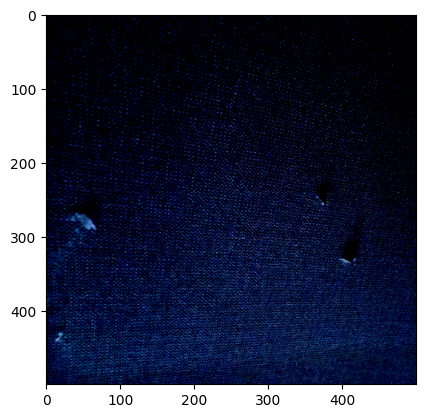

In [23]:

plt.imshow(sample_image.permute(1, 2, 0))


In [24]:

!nvidia-smi


Tue Apr 18 05:53:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
conv_block1 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU(),
                                
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU(),  

                                nn.MaxPool2d(kernel_size=2, stride=2)
                                ) # [16, 64, 112, 112]

conv_block1_out = conv_block1(images)                                     
conv_block1_out.shape      

torch.Size([16, 64, 250, 250])

In [26]:
conv_block2 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=128),                                      
                                nn.ReLU(),

                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=128),                                      
                                nn.ReLU(),      

                                nn.MaxPool2d(kernel_size=2, stride=2)
                                ) # [16, 128, 56, 56]
conv_block2_out = conv_block2(conv_block1_out)                                     
conv_block2_out.shape    

torch.Size([16, 128, 125, 125])

In [27]:
conv_block3 = nn.Sequential(
                                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=256),                                      
                                nn.ReLU(), 

                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=256),                                      
                                nn.ReLU(),   

                                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.MaxPool2d(kernel_size=2, stride=2)                                                                                         
                                ) # [16, 512, 28, 28]  

conv_block3_out = conv_block3(conv_block2_out)                                     
conv_block3_out.shape     

torch.Size([16, 512, 62, 62])

In [28]:
conv_block4 = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.MaxPool2d(kernel_size=2, stride=2)                                                                                           
                                ) # [16, 512, 14, 14] 
conv_block4_out = conv_block4(conv_block3_out)                                     
conv_block4_out.shape    

torch.Size([16, 512, 31, 31])

In [29]:
conv_block5 = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   
                                
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.MaxPool2d(kernel_size=2, stride=2)                                   
                                ) # [16, 512, 7, 7]   

conv_block5_out = conv_block5(conv_block4_out)                                     
conv_block5_out.shape   

torch.Size([16, 512, 15, 15])

In [30]:
avg_pool = nn.AdaptiveAvgPool2d((1, 1)) 
avg_pool_out = avg_pool(conv_block5_out)
avg_pool_out.shape

torch.Size([16, 512, 1, 1])

In [31]:
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block1 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU(),
                                
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU(),  

                                nn.MaxPool2d(kernel_size=2, stride=2)
                                ) # [16, 64, 112, 112]
    self.conv_block2 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=128),                                      
                                nn.ReLU(),

                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=128),                                      
                                nn.ReLU(),      

                                nn.MaxPool2d(kernel_size=2, stride=2)
                                ) # [16, 128, 56, 56]

    self.conv_block3 = nn.Sequential(
                                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=256),                                      
                                nn.ReLU(), 

                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=256),                                      
                                nn.ReLU(),   

                                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.MaxPool2d(kernel_size=2, stride=2)                                                                                         
                                ) # [16, 512, 28, 28]   

    self.conv_block4 = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),  

                                nn.MaxPool2d(kernel_size=2, stride=2)                                                                                           
                                ) # [16, 512, 14, 14] 

    self.conv_block5 = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   
                                
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=512),                                      
                                nn.ReLU(),   

                                nn.MaxPool2d(kernel_size=2, stride=2)                                   
                                ) # [16, 512, 7, 7]   

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # [16, 512, 1, 1]                                                                                                                              

    self.classifier = nn.Sequential(
                                nn.Linear(in_features=512, out_features=64),
                                nn.BatchNorm1d(num_features=64),
                                nn.ReLU(),
                                nn.Linear(in_features=64, out_features=19)
                                )

  def forward(self, x):
    x = self.conv_block1(x) # [16, 64, 112, 112]
    x = self.conv_block2(x) # [16, 128, 56, 56]
    x = self.conv_block3(x) # [16, 512, 28, 28] 
    x = self.conv_block4(x) # [16, 512, 14, 14]
    x = self.conv_block5(x) # [16, 512, 7, 7]
    x = self.avg_pool(x) # [16, 512, 1, 1] 
    
    # reshape할 형상 : (batch_size x 512)
    # x = x.view(-1, 512) # option 1 : view
    x = torch.flatten(x, 1) # option 2 : flatten 
    # x = x.reshape(x.shape[0], -1) # option 3 : reshape

    x = self.classifier(x)    
    return x

In [ ]:
model = VGG16()
model.to(device)
model

In [ ]:
out = model(images.to(device))
out.shape

In [ ]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

In [ ]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

# 모델 훈련

In [ ]:

writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        # tensorboard 시각화를 위한 로그 이벤트 등록
        writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
        writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
        writer.add_scalars('Train Loss and Valid Loss',
                          {'Train' : train_loss/len(trainloader),
                            'Valid' : valid_loss/len(validloader)}, epoch+1)
        writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
        # -------------------------------------------

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, 'best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!')
            writer.flush()   
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        
  writer.flush()
  return


In [ ]:

def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy


In [ ]:

# Commented out IPython magic to ensure Python compatibility.
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

In [ ]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [ ]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict = torch.load('/content/last_checkpoint.pth')


In [ ]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

In [ ]:
last_model.eval()
# evaluation(last_model, testloader, loss_fn)  

In [ ]:
last_state_dict['conv_block1.0.weight']

In [ ]:
# valid loss or accuracy 기준 best model
best_state_dict = torch.load('/content/best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

In [ ]:
best_model.eval()
# evaluation(best_model, testloader, loss_fn)

In [ ]:
test_set = glob.glob('/content/drive/MyDrive/data/test/*.png')
test_set.sort()
test_set

In [ ]:
testset = MyData(test_set, None,transform=transform)


In [ ]:
testloader = DataLoader(testset,batch_size=batch_size, shuffle=False)
images = next(iter(testloader))

In [ ]:

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    # preds = encoding.inverse_transform(preds)
    return preds



In [ ]:

preds = inference(last_model, testloader, device)

In [ ]:
submit = pd.read_csv('/content/baseline_submit.csv')

In [ ]:

submit['label'] = preds
submit['label'].head()
# submit['label'].value_counts()

In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit['label'].head()

In [ ]:

submit.to_csv('./DECAY_LAST_LR_041_BS_16_VGG.csv', index=False)


In [ ]:
preds = inference(best_model, testloader, device)

In [ ]:
submit = pd.read_csv('/content/baseline_submit.csv')

In [ ]:

submit['label'] = preds
submit['label'].head()
# submit['label'].value_counts()

In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit['label'].head()

In [ ]:
submit.to_csv('./DECAY_BEST_LR_041_BS_16_VGG.csv', index=False)

In [ ]:
preds = inference(model, testloader, device)

In [ ]:
submit = pd.read_csv('/content/baseline_submit.csv')

In [ ]:

submit['label'] = preds
submit['label'].head()
# submit['label'].value_counts()

In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit['label'].head()

In [ ]:
submit.to_csv('./DECAY_LR_041_BS_16_VGG.csv', index=False)